# 5.

Consider the model
$$ y_j \sim Binomial(n_j, \theta_j) $$
$$ \theta_j = logit^{-1}(\alpha + \beta x_j) $$
$$ \alpha \sim t_4(0, 2^2) $$
$$ \beta \sim t_4(0, 1) $$

Suppose J = 10, $x_j \sim U(0, 1)$, and $n_j \sim Poisson^+(5)$, i.e. > 0

In [1]:
import numpy as np
import scipy
from math import factorial
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

## visualize the priors

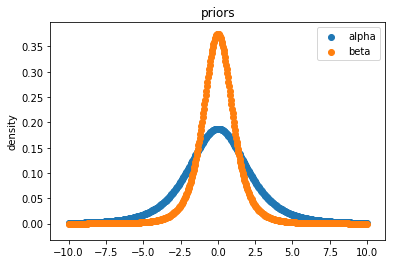

In [3]:
x = np.linspace(-10, 10, num=500)
plt.scatter(x=x, y=scipy.stats.t.pdf(x, df=4, scale=2), label="alpha")
plt.scatter(x=x, y=scipy.stats.t.pdf(x, df=4, scale=1), label="beta")
plt.title("priors")
plt.ylabel("density")
plt.legend()

In [4]:
def simulate_data(J, lam, seed):
    if seed:
        np.random.seed(seed)
    alpha = scipy.stats.t.rvs(df=4, scale=2, size=1)
    beta = scipy.stats.t.rvs(df=4, size=1)
    x = np.random.uniform(size=J)
    theta = inv_logit(alpha + beta * x)
    n = np.random.poisson(lam=lam, size=J)
    while np.min(n) <= 0:
        n[np.argmin(n)] = np.random.poisson(lam=lam, size=1)
    y = [np.random.binomial(n[i], theta[i]) for i in range(J)]
    print("alpha=%f, beta=%f" % (alpha, beta))
    return x, y, n

alpha=0.065686, beta=-0.246490


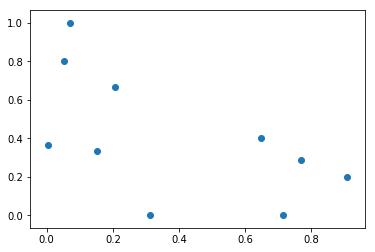

In [5]:
LAMBDA = 5
X, Y, N = simulate_data(J=10, lam=LAMBDA, seed=930)
plt.scatter(X, Y / N)

(b) Use rejection sampling to get 1000 independent posterior draws from $(\alpha, \beta)$

* the posterior $f(\alpha, \beta | y, n) \propto f(y, n | \alpha, \beta) f(\alpha) f(\beta)$ using independence of priors

* the likelihood for one observation is 
$$ f(y, n | \alpha, \beta) = f(y | n, \alpha, \beta) f(n | \alpha, \beta)$$
$$ f(y, n | \alpha, \beta) = p^y (1-p)^{n-y} {n \choose y} f(n)$$
* Since $n$ is nonnegative, $$f(n) = \frac{5^n}{n! (e^5 - 1)}$$
* $p$ depends on $\alpha, \beta$

In [6]:
# loglikelihood of data, given parameters
def loglikelihood(alpha, beta):
    llh = 0
    p = inv_logit(alpha + beta * X)
    # binomial part
    llh += (Y * np.log(p) + (N - Y) * np.log(1 - p) + np.log(scipy.special.comb(N, Y))).sum()
    # probability of n
    llh += (N * np.log(LAMBDA) - np.log(scipy.special.factorial(N)) - np.log(np.exp(LAMBDA) - 1)).sum()
    return llh

def target_log_density(alpha, beta):
    log_density_alpha = scipy.stats.t.logpdf(alpha, df=4, scale=2)
    log_density_beta = scipy.stats.t.logpdf(beta, df=4, scale=1)
    return loglikelihood(alpha, beta) + log_density_alpha + log_density_beta

assert isinstance(target_log_density(0, 0), float)

In [7]:
# for large LAMBDA and J, the MLE solution should be pretty close to the true solution
# this is just a check that I've implemented the above functions correctly
def neg_loglikelihood(params):
    return -1 * loglikelihood(*params)

mle = scipy.optimize.minimize(neg_loglikelihood, np.random.normal(size=2))
mle.x

array([ 0.05250586, -1.44227084])

In [8]:
H = np.linalg.inv(mle.hess_inv)
mle

      fun: 36.69320390516619
 hess_inv: array([[ 0.17333962, -0.26415418],
       [-0.26415418,  0.85837772]])
      jac: array([0.00000000e+00, 4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([ 0.05250586, -1.44227084])

### rejection sampling

Use a bivariate normal distribution as our approximating density, $g(\theta)$, to the target density, $p(\theta | y)$, but using the mle mean and variance

In [9]:
def approx_log_density(alpha, beta):
    """ This is a true density"""
    return scipy.stats.multivariate_normal.logpdf([alpha, beta],
                                                  mean=mle.x,
                                                  cov=H)

In [10]:
# find M, an upper bound on the ratio of target / approximate density
def minimize_me(params):
    return approx_log_density(*params) - target_log_density(*params)
res = scipy.optimize.minimize(minimize_me, np.random.normal(size=2))
res

      fun: 36.41606184466714
 hess_inv: array([[ 0.1756934 , -0.24540869],
       [-0.24540869,  0.67663704]])
      jac: array([-4.76837158e-07, -4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([-0.37126618, -0.21959417])

In [11]:
# this seems to scale linearly with J
# also: for other values of (sampled) alpha, beta, this was VERY large
log_M = -res.fun
log_M

-36.41606184466714

In [12]:
def rejection_sample(desired_samples: int):
    n_rejected = 0
    samples = []
    while len(samples) < desired_samples:
        sample = scipy.stats.multivariate_normal.rvs(mean=mle.x, cov=H, size=1)
        log_p = target_log_density(*sample) - log_M - approx_log_density(*sample)
        if np.log(np.random.uniform()) < log_p:
            samples.append(sample)
        else:
            n_rejected += 1
    print("acceptance rate was %f" %  (len(samples) / (len(samples) + n_rejected)))
    return np.array(samples)

In [13]:
%%time
rej_samples = rejection_sample(desired_samples=1000)

acceptance rate was 0.039628
CPU times: user 18.4 s, sys: 80.4 ms, total: 18.5 s
Wall time: 18.4 s


/Users/timothysweetser/.pyenv/versions/3.6.6/envs/work3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'Posterior, Rejection Sampling')

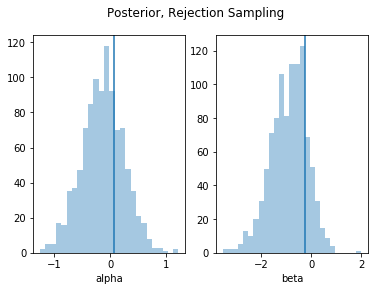

In [14]:
alpha=0.065686
beta=-0.246490

fig, axs = plt.subplots(1,  2, sharex=False)
sns.distplot(rej_samples[:, 0], kde=False, ax=axs[0])
axs[0].set_xlabel("alpha")
axs[0].axvline(x=alpha)

sns.distplot(rej_samples[:, 1], kde=False, ax=axs[1])
axs[1].set_xlabel("beta")
axs[1].axvline(x=beta)
fig.suptitle("Posterior, Rejection Sampling")

# (c) Approximate the posterior density by a normal centered at the posterior mode with covariance matrix fit to the curvature at that mode

In [15]:
def neg_target_log_density(params):
    return -1 * target_log_density(*params)

map_estimate = scipy.optimize.minimize(neg_target_log_density, x0=mle.x)
map_estimate


      fun: 39.967611771276275
 hess_inv: array([[ 0.1344616 , -0.15143763],
       [-0.15143763,  0.47302894]])
      jac: array([-3.81469727e-06, -4.76837158e-06])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([-0.15794549, -0.76707005])

This should be smaller than the mle estimate, owing to the zero-centered priors

In [16]:
assert np.abs(res.x[1]) < np.abs(mle.x[1])
#assert np.abs(res.x[0]) < np.abs(mle.x[0]) #why does this one fail?

In [17]:
t = 20 * (-1/2 + np.random.uniform(size=1000))
# joint density
#normal_density = scipy.stats.multivariate_normal.pdf(x, mean=res.x, cov=np.linalg.inv(res.hess_inv))
cov = np.linalg.inv(res.hess_inv)
# marginal densities
normal_density = {
    'alpha': scipy.stats.norm.pdf(t, loc=res.x[0], scale=np.sqrt(cov[0, 0])),
    'beta': scipy.stats.norm.pdf(t, loc=res.x[1], scale=np.sqrt(cov[1, 1])),                                   
}


Text(0.5, 0.98, 'Normal Approximation to Posterior')

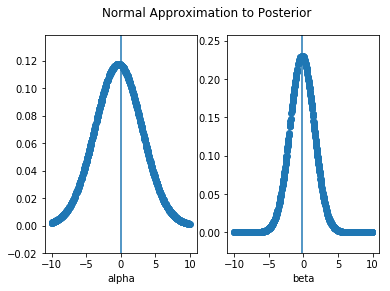

In [18]:
fig, axs = plt.subplots(1,  2, sharex=False)
axs[0].scatter(t, normal_density['alpha'])
axs[0].set_xlabel("alpha")
axs[0].axvline(x=alpha)

axs[1].scatter(t, normal_density['beta'])
axs[1].set_xlabel("beta")
axs[1].axvline(x=beta)
fig.suptitle("Normal Approximation to Posterior")

# (d) Importance sampling

In [19]:
# https://github.com/statsmodels/statsmodels/blob/master/statsmodels/sandbox/distributions/multivariate.py
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    n : int
        number of observations, return random array will be (n, len(m))
    Returns
    -------
    rvs : ndarray, (n, len(m))
        each row is an independent draw of a multivariate t distributed
        random variable
    '''
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None] # same output format as random.multivariate_normal

In [20]:
samples = multivariate_t_rvs(m=map_estimate.x, S=np.linalg.inv(map_estimate.hess_inv),
                             df=4, n=1000)
# make into a list
samples = [tuple(samples[i, :]) for i in range(1000)]
importance_weights = np.exp([target_log_density(*s) - approx_log_density(*s)
                            for s in samples])

/Users/timothysweetser/.pyenv/versions/3.6.6/envs/work3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


/Users/timothysweetser/.pyenv/versions/3.6.6/envs/work3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/timothysweetser/.pyenv/versions/3.6.6/envs/work3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'Should be constant')

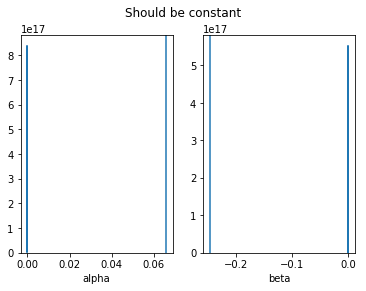

In [21]:
# this quantity should be roughly constant, if importance sampling is to work well
ratios = {
    'alpha': np.array([s[0] for s in samples]) * \
    np.exp([target_log_density(*s) for s in samples]) / \
    np.exp([approx_log_density(*s) for s in samples]),
    'beta': np.array([s[1] for s in samples]) * \
    np.exp([target_log_density(*s) for s in samples]) / \
    np.exp([approx_log_density(*s) for s in samples])
}

fig, axs = plt.subplots(1,  2, sharex=False)
sns.distplot(ratios['alpha'], kde=True, ax=axs[0])
axs[0].set_xlabel("alpha")
axs[0].axvline(x=alpha)

sns.distplot(ratios['beta'], kde=True, ax=axs[1])
axs[1].set_xlabel("beta")
axs[1].axvline(x=beta)
fig.suptitle("Should be constant")

In [22]:
E_alpha = np.inner(np.array([s[0] for s in samples]), importance_weights) / importance_weights.sum()
E_beta = np.inner(np.array([s[1] for s in samples]), importance_weights) / importance_weights.sum()
E_alpha, E_beta

(-0.27916457540367945, -0.5275266195567332)

In [23]:
alpha, beta

(0.065686, -0.24649)

In [24]:
# effective sample size is much smaller than our actual number of samples
1 / np.sum((importance_weights / importance_weights.sum())**2)

80.57123653621905

# fit this model using PyMC3 for comparison

In [25]:
import pymc3 as pm

In [26]:
J = 10

with pm.Model() as model:
    a = pm.StudentT('a', nu=4, mu=0, sd=2)
    b = pm.StudentT('b', nu=4, mu=0, sd=1)
    
    p = 1 / (1 + pm.math.exp(a + b * X))
    y = pm.Binomial('y', n=N, p=p, observed=Y)

In [27]:
with model:
    pm_samples = pm.sample(draws=2000, chains=4, cores=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3351.07draws/s]
The acceptance probability does not match the target. It is 0.8952223297053504, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118d298d0>,
      dtype=object)

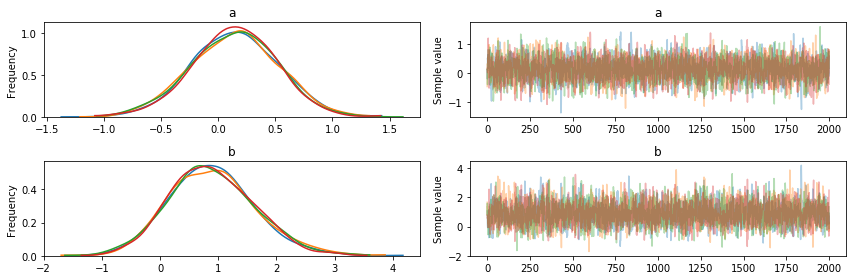

In [28]:
pm.traceplot(pm_samples)

In [30]:
pm_samples.get_values('a').mean()

0.1363808045275482

In [31]:
pm_samples.get_values('b').mean()

0.8834539424257732

In [32]:
alpha, beta

(0.065686, -0.24649)

# another approach: logistic regression

In [37]:
import statsmodels.formula.api as smf
import pandas as pd

In [48]:
df_agg = pd.DataFrame({'x': X, 'n_success': Y, 'n_trials': N})
df_agg['n_fail'] = df_agg['n_trials'] - df_agg['n_success']
# repeat so each row = 1 trial
df_success = df_agg.loc[np.repeat(df_agg.index, df_agg['n_success']), ['x']]
df_success['y'] = 1
assert len(df_success) == df_agg['n_success'].sum()
df_failure = df_agg.loc[np.repeat(df_agg.index, df_agg['n_fail']), ['x']]
df_failure['y'] = 0
assert len(df_failure) == df_agg['n_fail'].sum()
df = pd.concat([df_success, df_failure], axis='rows')
assert len(df) == np.sum(N)
df.sample(n=3)

,x,y
5,0.311063,0
7,0.150679,1
7,0.150679,1


In [49]:
smf.logit("y ~ x", data=df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.644577
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                          Logit   Df Residuals:                       46
Method:                           MLE   Df Model:                            1
Date:                Sun, 27 Jan 2019   Pseudo R-squ.:                 0.03979
Time:                        22:32:44   Log-Likelihood:                -30.940
converged:                       True   LL-Null:                       -32.222
                                        LLR p-value:                    0.1093
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0525      0.416      0.126      0.900      -0.764       0.869
x             -1.4423      0.930     -1.550      0.121      -3.266       0.381
==============================================================================
"""

This perfectly matches the MLE estimate above

In [50]:
mle.x

array([ 0.05250586, -1.44227084])

In [47]:
alpha, beta

(0.065686, -0.24649)